In this notebook, we are going to check the level2 satellite data generated using the different atmospheric corrections for the Kamchatka day-of remobilization event.

For the Kamchatka event, we have clear images on the day before, the day of, and the day after the event:

| Description | Day of year | File Name |
|:-:|:-:|:-:|
| Day before | 258 | A2015258013500 |
| Day of | 259 | A2015259022000 |
| Day after | 260 | A2015260012500 |

# Approach

Compare the chlorophyll-a data in the region of the plume and over the whole image for

1. default l2gen processing
2. fixed angstrom
3. fixed aod

These will be compared with the chlorophyll-a data from the day before and after the event too.

# Initializing

In [158]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import re
import pyproj as pp
%matplotlib inline

Setting file paths:

In [139]:
fileDir = 'C:/Users/cmitchell/SHARE/satellieFiles/volcano/'
satFiles = ['A2015258013500.L2','A2015259022000.L2','A2015259022000_taua_0-169_0-437.L2',
            'A2015259022000_ang0-578.L2','A2015260012500.L2']
keys = ['day258','day259-default','day259-aod','day259-ang','day260']
satPaths = [fileDir + sf for sf in satFiles]
fileList = dict(zip(keys,satFiles))

# Working with one file

Let's develop the method for 1 file only.

### Loading file:

In [122]:
sf = satPaths[0]
data_geo = xr.load_dataset(sf,group='geophysical_data')
data_nav = xr.load_dataset(sf,group='navigation_data')

### 180th Meridian
Note, because the files cross the 180 meridian, but our region of interest doesn't, let's set the geophysical data to NaN (*not the lats and longs, the mapping doesn't like that...*)

In [123]:
ind = data_nav.longitude.data < 0
data_geo = xr.where(ind,np.nan,data_geo)

### Subscening

Next, let's subscene the data. 

In [125]:
lonE = 164
lonW = 162.5
latN = 56
latS = 55.3

Making the index array:

In [126]:
lats = data_nav.latitude.data
lons = data_nav.longitude.data

lon_idx = (lons < lonE) & (lons > lonW)
lat_idx = (lats < latN) & (lats > latS)
latlon_idx = lon_idx & lat_idx

Subsetting the DataSet

In [127]:
data_geo_plume = data_geo.where(latlon_idx)

Checking via a plot:

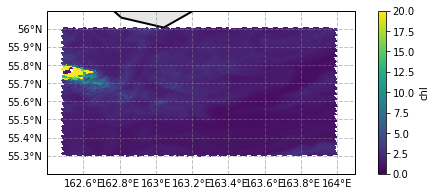

In [128]:
plt.figure(figsize=(8,3))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set lat and long limits here
ax.set_extent([lonW-0.1,lonE+0.1,latS-0.1,latN+0.1])

#doing the gridlines, haven't figured out how to
#do the xticks neatly, so for now, I'm keeping the 
#grey gridlines on the image
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#adding land
land = cfeature.GSHHSFeature(
        scale='l',lw=2,
        facecolor=[0.9,0.9,0.9])
ax.add_feature(land)

#plotting the satellite data
plt.pcolormesh(data_nav.longitude.data, data_nav.latitude.data, 
           np.ma.masked_where(np.isnan(data_geo_plume.chlor_a),data_geo_plume.chlor_a), 
             transform=ccrs.PlateCarree(),zorder=2,
              vmin=0,vmax=20)
plt.colorbar(label='chl')

OK this seems to have worked

### Analysis of chlorophyll-a

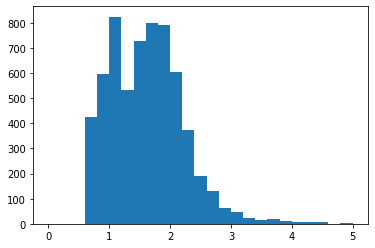

In [129]:
plt.figure(figsize=(6,4))
plt.hist(data_geo_plume['chlor_a'].data.flatten(),bins=25,range=(0,5));

In [130]:
statistics = {}
DATA = data_geo_plume['chlor_a']

statistics['chlor_a'] = [np.nanmin(DATA),np.nanmax(DATA),np.nanmedian(DATA),np.nanmean(DATA),
            np.nanstd(DATA),stats.mstats.gmean(DATA.data.flatten()[~np.isnan(DATA.data.flatten())])]

statistics = pd.DataFrame.from_dict(statistics,orient='index',columns=['min','max','median','mean','stdev','geo mean'])

In [131]:
statistics

,min,max,median,mean,stdev,geo mean
chlor_a,0.60961,246.818176,1.613077,1.942198,5.223923,1.559742


# Analysing all files

First, let's create xarray DataSets for the data

In [140]:
geophys = {}
nav = {}
geophys_plume = {}
for key,file in fileList.items():
    #importing data
    geophys[key] = xr.load_dataset(fileDir + file,group='geophysical_data')
    nav[key] = xr.load_dataset(fileDir + file,group='navigation_data')
    
    #subscening
    lonE = 164
    lonW = 162.5
    latN = 56
    latS = 55.3
    
    lon_idx = (nav[key].longitude.data < lonE) & (nav[key].longitude.data > lonW)
    lat_idx = (nav[key].latitude.data < latN) & (nav[key].latitude.data > latS)
    latlon_idx = lon_idx & lat_idx
    
    geophys_plume[key] = geophys[key].where(latlon_idx)
    geophys_plume[key]['latitude'] = nav[key].latitude
    geophys_plume[key]['longitude'] = nav[key].longitude

### Histograms and statistics
Now, let's plot the histograms and do the stats for the plume region:

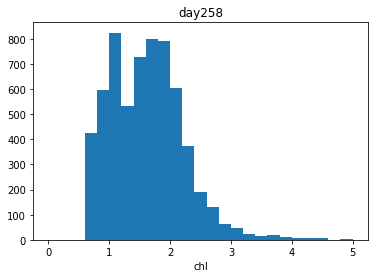

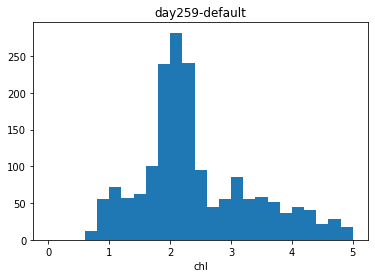

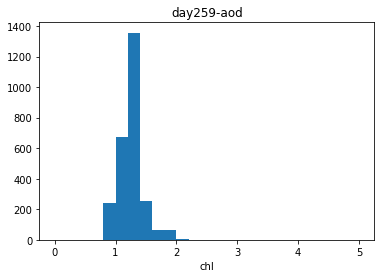

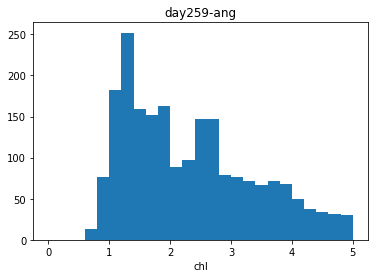

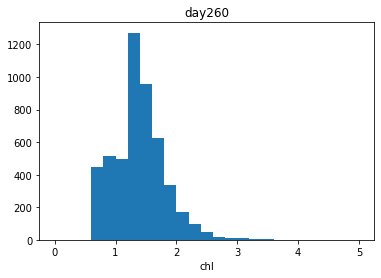

In [141]:
statistics = {}
for key,ds in geophys_plume.items():
    
    plt.figure(figsize=(6,4))
    plt.hist(ds['chlor_a'].data.flatten(),bins=25,range=(0,5));
    plt.title(key)
    plt.xlabel('chl')
    
    DATA = ds['chlor_a']

    statistics[key] = [np.nanmin(DATA),np.nanmax(DATA),np.nanmedian(DATA),np.nanmean(DATA),
                np.nanstd(DATA),stats.mstats.gmean(DATA.data.flatten()[~np.isnan(DATA.data.flatten())])]

statistics = pd.DataFrame.from_dict(statistics,orient='index',columns=['min','max','median','mean','stdev','geo mean'])

In [142]:
statistics

,min,max,median,mean,stdev,geo mean
day258,0.609610,246.818176,1.613077,1.942198,5.223923,1.559742
day259-default,0.671551,459.562866,3.005110,20.044556,52.632446,5.061064
day259-aod,0.821314,2.458068,1.291035,1.263280,0.202247,1.247684
day259-ang,0.691804,344.121399,2.600060,6.276837,18.233677,3.030150
day260,0.604293,4.796502,1.368604,1.389504,0.423300,1.326084


### Plots of the plume region

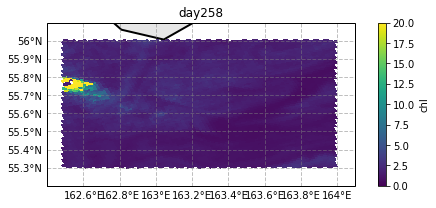

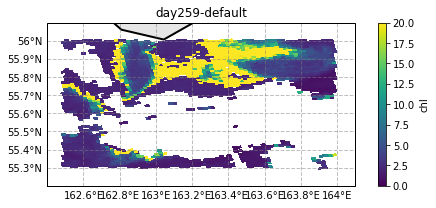

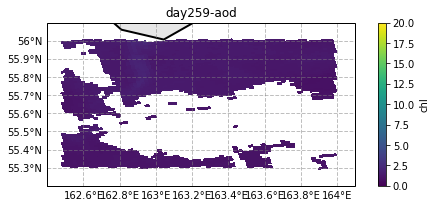

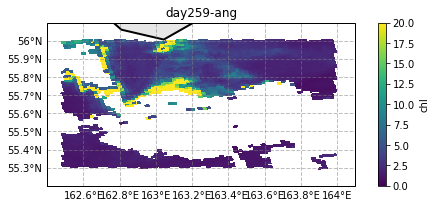

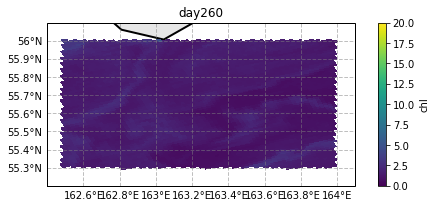

In [143]:
for key,ds in geophys_plume.items():
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW-0.1,lonE+0.1,latS-0.1,latN+0.1])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #plotting the satellite data
    plt.pcolormesh(nav[key].longitude.data, nav[key].latitude.data, 
               np.ma.masked_where(np.isnan(ds.chlor_a),ds.chlor_a), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  vmin=0,vmax=20)
    plt.colorbar(label='chl')
    plt.title(key)

### Plots of a wider region

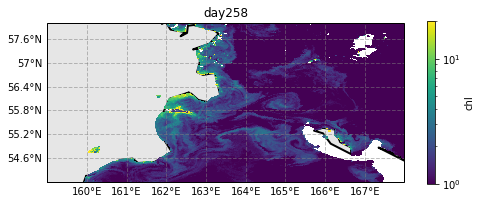

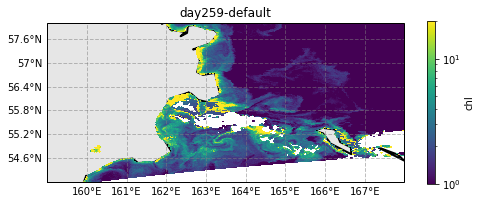

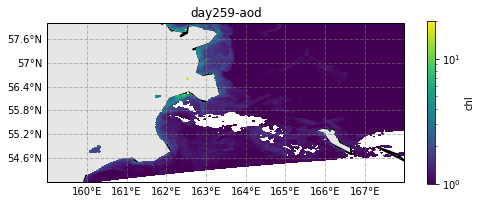

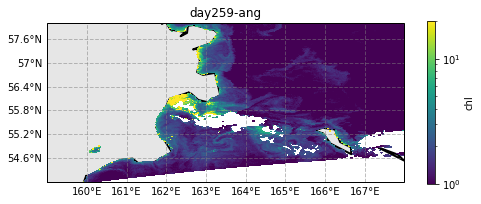

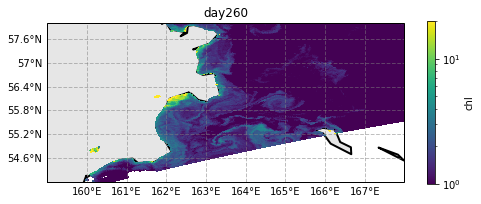

In [144]:
lonE = 168
lonW = 159
latN = 58
latS = 54

for key,ds in geophys.items():
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW,lonE,latS,latN])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #plotting the satellite data
    norm= colors.LogNorm(vmin=1, vmax=20)
    plt.pcolormesh(nav[key].longitude.data, nav[key].latitude.data, 
               np.ma.masked_where(np.isnan(ds.chlor_a),ds.chlor_a), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  norm=norm)
    plt.colorbar(label='chl')
    plt.title(key)

### Differences

What is the difference in the chl product for the different methods?

#### Difference with day 258

First we need to pull out only the day 259 days:

In [156]:
regex = re.compile('day259-')
day259keys = [kk for kk in keys if regex.search(kk)]

Then we need to project the data onto the same grids *before* doing the subraction. In the above plots, the mapping is just done for the visualization. Cartopy was designed for visualizing mapped data: it doesn't have functions to actually do the projections and save the output in an array. It seems like it is going to be a MAJOR challenge to do the projections on the data... I've searched for other python modules that might help but can't find anything suitable. I think I'm going to have to bin the data myself. The other option is to use some of the binning & mapping commands within SeaDAS - these are specifically designed for binning, taking into account flag info, etc. I'm going to start a new notebook to focus on that and re-do the above analysis on the binned files.

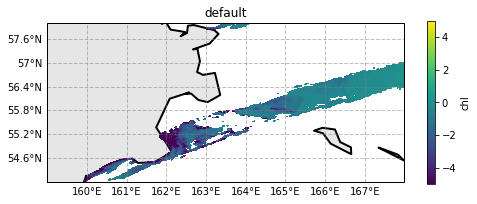

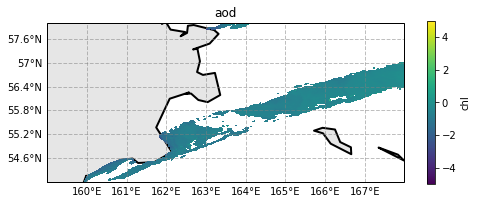

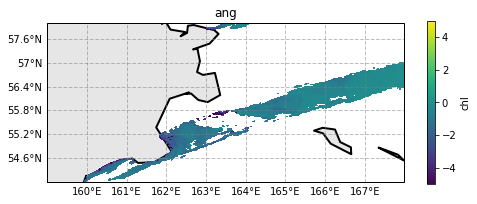

In [157]:
for key in day259keys:
    ds = geophys[key]
    diffs = geophys['day258'].chlor_a - ds.chlor_a
    
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW,lonE,latS,latN])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #plotting the satellite data
    #norm= colors.LogNorm(vmin=1, vmax=20)
    plt.pcolormesh(nav[key].longitude.data, nav[key].latitude.data, 
               np.ma.masked_where(np.isnan(diffs),diffs), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  vmin=-5,vmax=5)#norm=norm)
    plt.colorbar(label='chl')
    plt.title(key[7:])